# Natural Language Processing

In this notebook we will be attempting to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews.

We will use the Yelp Review Data Set from Kaggle.

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users.

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

Let's get started

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
yelp = pd.read_csv("yelp.csv")

In [3]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


In [5]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


#### Creating a new column for text length.

In [6]:
yelp['text_length'] = yelp['text'].apply(len)

In [7]:
yelp.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text_length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345


### EDA

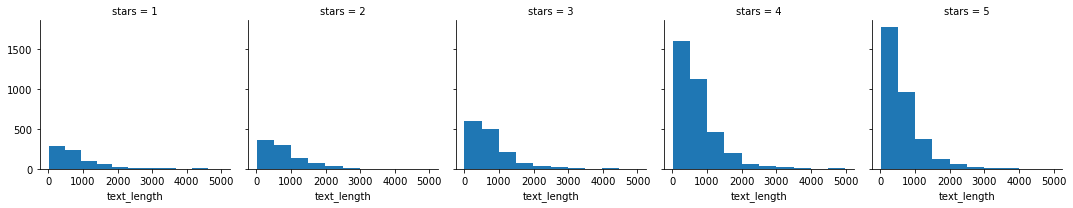

In [8]:
g = sns.FacetGrid(yelp,col='stars')
g.map(plt.hist,'text_length')

#### Create a boxplot of text length for each star category.

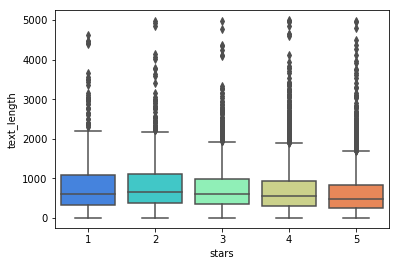

In [9]:
sns.boxplot(x='stars',y='text_length',data=yelp,palette='rainbow')

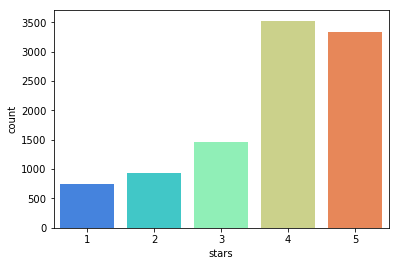

In [10]:
sns.countplot(x= 'stars', data= yelp, palette= 'rainbow')

#### Use groupby to get the mean values of the numerical columns

In [11]:
stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text_length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [12]:
stars.corr()

,cool,useful,funny,text_length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text_length,-0.857664,0.699881,0.843461,1.000000


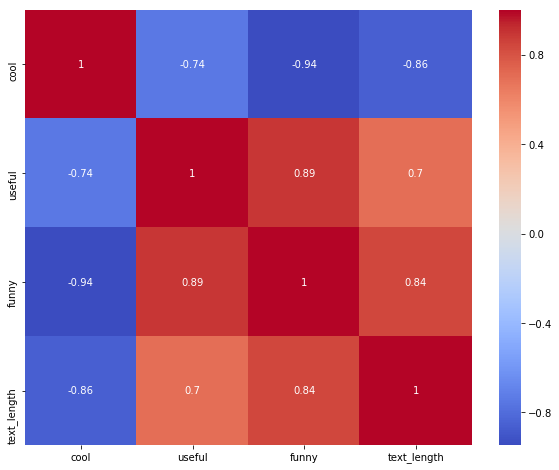

In [13]:
plt.figure(figsize= (10,8))
sns.heatmap(stars.corr(),cmap='coolwarm',annot=True)

## Text Preprocessing

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

In [14]:
X = yelp['text']
Y = yelp['stars']

In [15]:
import string
from nltk.corpus import stopwords

def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Original X:

In [16]:
X.head()

0    My wife took me here on my birthday for breakf...
1    I have no idea why some people give bad review...
2    love the gyro plate. Rice is so good and I als...
3    Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
4    General Manager Scott Petello is a good egg!!!...
Name: text, dtype: object

Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

Let's see an example output:

In [17]:
X.head(5).apply(text_process)

0    [wife, took, birthday, breakfast, excellent, w...
1    [idea, people, give, bad, reviews, place, goes...
2    [love, gyro, plate, Rice, good, also, dig, can...
3    [Rosie, Dakota, LOVE, Chaparral, Dog, Park, co...
4    [General, Manager, Scott, Petello, good, egg, ...
Name: text, dtype: object

## Vectorization

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the analyzer to be our own previously defined function

In [19]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [20]:
print(len(bow_transformer.vocabulary_))

44012


Let's take one text and get its bag-of-words counts as a vector, putting to use our new bow_transformer

In [21]:
x4 = X[3]
print(x4)

Rosie, Dakota, and I LOVE Chaparral Dog Park!!! It's very convenient and surrounded by a lot of paths, a desert xeriscape, baseball fields, ballparks, and a lake with ducks.

The Scottsdale Park and Rec Dept. does a wonderful job of keeping the park clean and shaded.  You can find trash cans and poopy-pick up mitts located all over the park and paths.

The fenced in area is huge to let the dogs run, play, and sniff!


In [22]:
bow4 = bow_transformer.transform([x4])
print(bow4)
print(bow4.shape)

  (0, 3531)	1
  (0, 4509)	1
  (0, 4681)	1
  (0, 4850)	1
  (0, 8110)	1
  (0, 10435)	2
  (0, 11359)	1
  (0, 11676)	1
  (0, 12209)	1
  (0, 16219)	1
  (0, 16834)	1
  (0, 17001)	1
  (0, 18681)	1
  (0, 19639)	1
  (0, 20471)	1
  (0, 21834)	1
  (0, 22456)	1
  (0, 22841)	1
  (0, 24270)	1
  (0, 24316)	1
  (0, 24393)	1
  (0, 27490)	1
  (0, 28656)	1
  (0, 28824)	1
  (0, 29109)	1
  (0, 29407)	1
  (0, 29686)	1
  (0, 29818)	1
  (0, 30985)	1
  (0, 33109)	2
  (0, 33236)	2
  (0, 33949)	1
  (0, 34130)	1
  (0, 36558)	1
  (0, 37500)	1
  (0, 38362)	1
  (0, 39888)	1
  (0, 41406)	1
  (0, 43549)	1
  (0, 43745)	1
(1, 44012)


Three words appear twice, the rest only once. Let's go ahead and check and confirm which ones appear twice

In [23]:
print(bow_transformer.get_feature_names()[10435])
print(bow_transformer.get_feature_names()[33109])
print(bow_transformer.get_feature_names()[33236])

Park
park
paths


Now we can use .transform on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire corpus is a large, sparse matrix

In [24]:
messages_bow = bow_transformer.transform(X)

In [25]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (10000, 44012)
Amount of Non-Zero occurences:  583230


In [26]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


After the counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidfTransformer

## Model Training - I

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(messages_bow, Y,test_size=0.3,random_state=101)

In [29]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [30]:
nb.fit(X_train, y_train)

pred = nb.predict(X_test)
probab = nb.predict_proba(X_test)

In [31]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,log_loss

In [32]:
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))
print(accuracy_score(y_test,pred))
print(log_loss(y_test,probab))

             precision    recall  f1-score   support

          1       0.75      0.20      0.31       220
          2       0.16      0.03      0.04       273
          3       0.23      0.04      0.07       443
          4       0.41      0.75      0.53      1064
          5       0.58      0.51      0.54      1000

avg / total       0.44      0.46      0.40      3000

[[ 43  24  10 102  41]
 [  7   7  19 213  27]
 [  1   7  18 360  57]
 [  3   2  20 794 245]
 [  3   4  11 474 508]]
0.456666666667
4.24965163641


In [33]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
probab = lr.predict_proba(X_test)

In [34]:
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))
print(accuracy_score(y_test,pred))
print(log_loss(y_test,probab))

             precision    recall  f1-score   support

          1       0.57      0.40      0.47       220
          2       0.39      0.28      0.33       273
          3       0.39      0.31      0.34       443
          4       0.48      0.51      0.49      1064
          5       0.54      0.63      0.58      1000

avg / total       0.48      0.49      0.48      3000

[[ 87  46  15  29  43]
 [ 38  77  68  59  31]
 [ 12  42 138 177  74]
 [  6  20 108 540 390]
 [ 10  11  29 319 631]]
0.491
1.52926741913


## Model Training - II

In [35]:
from sklearn.feature_extraction.text import  TfidfTransformer

In [36]:
from sklearn.pipeline import Pipeline

In [37]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.3,random_state=101)

In [39]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [40]:
predictions = pipeline.predict(X_test)

In [41]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[  0   0   0 187  33]
 [  0   0   0 266   7]
 [  0   0   1 422  20]
 [  0   0   0 974  90]
 [  0   0   0 708 292]]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       220
          2       0.00      0.00      0.00       273
          3       1.00      0.00      0.00       443
          4       0.38      0.92      0.54      1064
          5       0.66      0.29      0.40      1000

avg / total       0.50      0.42      0.33      3000

0.422333333333


/home/aman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Model Training - III

In [42]:
cvec = CountVectorizer()

In [43]:
X = cvec.fit_transform(X)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.3,random_state=101)

In [45]:
nb.fit(X_train, y_train)

pred = nb.predict(X_test)
probab = nb.predict_proba(X_test)

In [46]:
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))
print(accuracy_score(y_test,pred))
print(log_loss(y_test,probab))

             precision    recall  f1-score   support

          1       0.66      0.26      0.37       220
          2       0.28      0.07      0.12       273
          3       0.32      0.08      0.13       443
          4       0.42      0.73      0.54      1064
          5       0.59      0.54      0.56      1000

avg / total       0.47      0.47      0.43      3000

[[ 57  35  12  79  37]
 [ 12  20  33 180  28]
 [  6   8  36 350  43]
 [  6   4  21 775 258]
 [  5   5   9 446 535]]
0.474333333333
3.82034312414


In [47]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
probab = lr.predict_proba(X_test)

In [48]:
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))
print(accuracy_score(y_test,pred))
print(log_loss(y_test,probab))

             precision    recall  f1-score   support

          1       0.62      0.46      0.53       220
          2       0.43      0.33      0.37       273
          3       0.38      0.34      0.36       443
          4       0.49      0.51      0.50      1064
          5       0.55      0.61      0.58      1000

avg / total       0.50      0.50      0.50      3000

[[102  42  22  21  33]
 [ 37  89  68  57  22]
 [ 12  46 151 160  74]
 [  7  14 124 545 374]
 [  7  16  36 327 614]]
0.500333333333
1.57046090043


## Model Training - IV

In [54]:
yelp_class = yelp[(yelp['stars']==1) | (yelp['stars']==3) | (yelp['stars']==5)]

In [55]:
X = yelp_class['text']
Y = yelp_class['stars']

In [61]:
X = cvec.fit_transform(X)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.3,random_state=101)

In [63]:
nb.fit(X_train, y_train)

pred = nb.predict(X_test)
probab = nb.predict_proba(X_test)

In [64]:
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))
print(accuracy_score(y_test,pred))
print(log_loss(y_test,probab))

             precision    recall  f1-score   support

          1       0.76      0.44      0.56       243
          3       0.64      0.58      0.61       442
          5       0.80      0.92      0.86       980

avg / total       0.75      0.76      0.75      1665

[[107  85  51]
 [ 13 255 174]
 [ 20  59 901]]
0.758558558559
1.6034067772


In [65]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
probab = lr.predict_proba(X_test)

In [66]:
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))
print(accuracy_score(y_test,pred))
print(log_loss(y_test,probab))

             precision    recall  f1-score   support

          1       0.77      0.63      0.69       243
          3       0.69      0.66      0.67       442
          5       0.85      0.90      0.87       980

avg / total       0.79      0.80      0.79      1665

[[152  53  38]
 [ 29 291 122]
 [ 17  77 886]]
0.798198198198
0.668451008605


In [67]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()

ada.fit(X_train, y_train)
pred = ada.predict(X_test)
probab = ada.predict_proba(X_test)

In [68]:
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))
print(accuracy_score(y_test,pred))
print(log_loss(y_test,probab))

             precision    recall  f1-score   support

          1       0.70      0.46      0.55       243
          3       0.60      0.48      0.53       442
          5       0.76      0.89      0.82       980

avg / total       0.71      0.72      0.70      1665

[[111  55  77]
 [ 28 210 204]
 [ 20  83 877]]
0.71951951952
1.06200833856
